In [1]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd

/opt/conda/envs/eurac_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_1120881/4015137556.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration

In [2]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform/old_data/data'

In [3]:
pv_geoms = gpd.read_file(f"{data_dir}/shapefiles/photovoltaic.shp")

In [4]:
# Filter the data to have farms bigger then 5 km2
threshold_area = 5000 #m^2 ~50mx100m
pv_geoms_32632 = pv_geoms.to_crs(32632)
big_pv_geoms_32632 = pv_geoms_32632.where(pv_geoms_32632["geometry"].area > threshold_area).dropna()
big_pv_geoms = big_pv_geoms_32632.to_crs(4326)
print(f"Number of selected PV Farms: {len(big_pv_geoms)}")

Number of selected PV Farms: 43


In [12]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

In [13]:
# Extract S2 data for the farms 
for i, geom in big_pv_geoms_32632.iterrows():
    data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")
    
    ## This step to fill the gaps (nan values) spatially
    data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
    #data_filled['crs'] = data.crs
    data.rio.write_crs("epsg:32633", inplace=True) #32633
    
    ## Filter clouds pixels
    cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
    geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
    data = data.where(~cloud_mask)
    
    ## Clip the farm polygon
    clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
      
    
    break

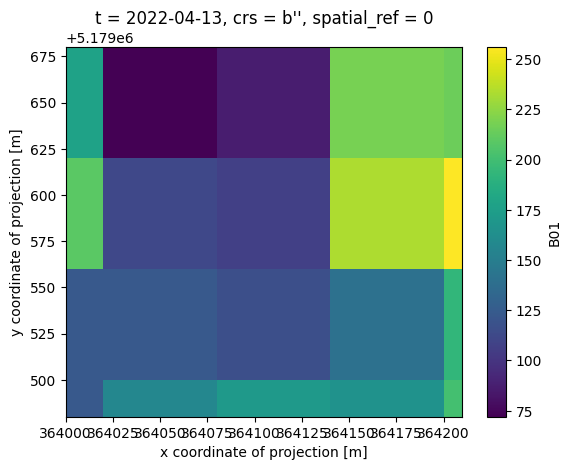

In [14]:
data['B01'][30].plot()

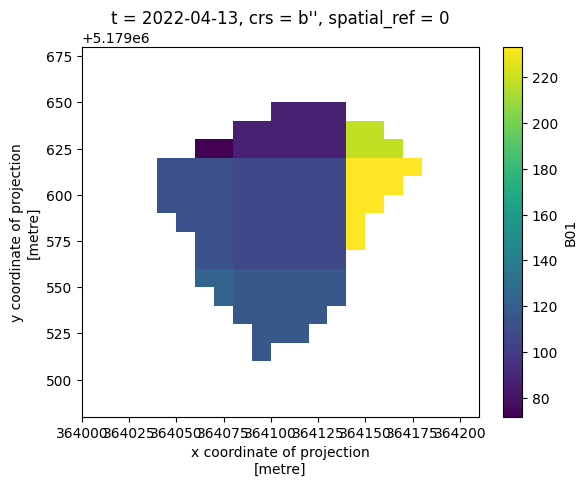

In [15]:
clipped['B01'][30].plot()

In [16]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[5:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [17]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

(8060, 11, 365)

In [18]:
y1 = np.ones(pv_samples.shape[0])

In [19]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[5:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [20]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

(22551, 11, 365)

In [21]:
y0 = np.zeros(non_pv_samples.shape[0])

#### Combine both PV and Non-PV togehter 

In [43]:
tr_data = np.vstack([pv_samples, non_pv_samples[:8000]])
y = np.hstack([y1, y0[:8000]])

In [44]:
print(tr_data.shape)
print(y.shape)

(16060, 11, 365)
(16060,)


### Modeling

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tsai.all import *

In [46]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    X, y, splits = combine_split_data([x_train, x_val], [y_train, y_val])
    
    tfms  = [None, [Categorize()]] #[TSStandardize()] #[None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 16], batch_tfms=[TSStandardize()], num_workers=0)

    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    
    learn.fit_one_cycle(5, lr_max=1e-3)

    # Validation
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    (valid_targets == valid_preds).float().mean()
    score = accuracy_score(valid_preds, valid_targets)
    print(f'Accuracy Score: {score}')
    i+=1
    break

########### Fold number 1 


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.show_probas()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Test 

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:5].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        
        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")
        
        
    break

In [ ]:
clipped['B01'][30].plot()

In [ ]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [ ]:
te_samples.shape

In [ ]:
test_ds = dls.dataset.add_test(te_samples)

In [ ]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)

In [ ]:
te_pred = np.array(np.argmax(test_probas, axis=1))
te_pred

In [ ]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [ ]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()